## Asymptotic formulae for likelihood-based tests for new physics

Authors: A. Ramirez-Morales (andres.ramirez@tec.mx), E. Gutierrez-Cortes (a01639119@tec.mx), A. De Dios-Ramos(a01643931@tec.mx)

## 1. Basic Concepts

1. Abstract
2. Search as a statistical test (frequentist)
3. Hypothesis Test
4. $p$-value
5. Significance Z
6. Field Applications
7. Histogram
8. Parameter of Interest
9. Nuissance Parameter
10. Likelihood
11. Profile Likelihood
12. Numerical Stability
13. $f(t_\mu \vert\mu)$ definition
14. What does a discovery mean in terms of statistics? 

### 1.1 Abstract

This notebook provides an approachable introduction to likelihood-based statistical tests as used in high energy physics. It walks through the core concepts needed to understand and apply these methods, including the frequentist view of searches as hypothesis tests, the interpretation of $p$-values and significance levels (Z), and the role of parameters of interest versus nuisance parameters. Using histograms to model observed data, we explore the construction and interpretation of likelihood and profile likelihood functions, numerical considerations, and the definition of key test statistics such as $f(t_{\mu}\vert \mu) f(t_μ​,μ)$. We also discuss what constitutes a discovery in statistical terms and outline the practical relevance of these ideas in particle physics experiments. This material is aimed at readers with a basic familiarity with statistics and a strong interest in their application to physics.

# 2. Counting Experiment

This example is referred in the literature as counting experiment (One bin analysis).

Consider an experiment where one observes a number of events $n$, assumed to follow a Poisson distribution.

 The following is the likelihood function, where $n$ are the main measurments and $m$ are control measurments to constrain the nuisance parameters. 

\begin{equation}
L(\mu, b) = \frac{(\mu s+b)^n}{n!} e^{-(\mu s+b)} \frac{(\tau b)^m}{m!}e^{-\tau b}
\end{equation}

Where $n$ and $m$ are given data, as well as $b, s$ and $\tau$ as followed in this first example:

In [1]:
# basic libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
b = 10
s = 10
tau = 1

## 2.1. Statistic $q_0$

The following probability density function (Eq. 48), describes the distribution of the discovery statistic $q_0$ when we assume that there is only background in data. This is the theory distribution found using Wald and Wilks aproximation. 
\begin{equation}
f(q_0|0) = \frac{1}{2} \delta(q_0)+ \frac{1}{2} \frac{1}{\sqrt{2\pi}}\frac{1}{\sqrt{q_0}}e^{-q_0/2}.
\end{equation}

The goal of this excercise is to show this aproximation is as good as the Monte Carlo simulation

In [2]:
def f_q0_given_0(q0):
    """
    EC.48 formula analitica
    """
    q0 = np.asarray(q0)
    result = np.zeros_like(q0, dtype=np.float64)
    # Dirac delta part (for q0 == 0)
    delta_flag = (q0 == 0)
    result[delta_flag] = 0.5
    # Continuous part (second part of Ec.(1))
    cont_flag = (q0 > 0)
    q0_pos = q0[cont_flag]
    result[cont_flag] = 0.5 * (1 / np.sqrt(2 * np.pi * q0_pos)) * np.exp(-0.5 * q0_pos)
    return result

To test a hypothesized value of $\mu$ we consider the profile likelihood ratio
\begin{equation}
\lambda(\mu) = \frac{L(\mu, \hat{\hat{\theta}}(\mu))}{L(\hat{\mu}, \hat{\theta})}
\end{equation}
Here the quantity $\hat{\hat{\theta}}$ denotes the value of $\theta$
that maximizes $L$ for the specified $\mu$ (conditional likelihood).

The denominator is the maximized (unconditional) likelihood function, i.e., $\hat{\mu}$ and $\hat{\theta}$ are their ML estimators.


The $q_0$ statistic,  is a test statistic designed to quantify how compatible is the observed data with the background-only hypothesis, meaning the discovery of positive signal. 
In the case where $\mu$ = 0 we obtain: 

\begin{equation}
q_0 = 
\begin{cases}
-2 \ln \lambda(0), & \hat{\mu} \geq 0, \\
0, & \hat{\mu} < 0.
\end{cases}
\end{equation}


The following function obtains the $q_0$ from data simulated with Monte Carlo:

In [3]:
def q0_estimator(n, m, s, mu, tau, mu_hat, b_hat, b_hat_mu):
    """Documentation missing"""
    like_cond = ((mu * s + b_hat_mu) ** n * np.exp(-(mu * s + b_hat_mu))) * \
                ((tau * b_hat_mu) ** m * np.exp(-(tau * b_hat_mu)))
    
    like_max = ((mu_hat * s + b_hat) ** n * np.exp(-(mu_hat * s + b_hat))) * \
               ((tau * b_hat) ** m * np.exp(-(tau * b_hat)))
    
    if like_cond == 0 or like_max == 0 or mu_hat < 0:
        return 0.0
    
    #if like_cond <= 0 or like_max <= 0 or np.isnan(like_cond) or np.isnan(like_max):
    #    return np.nan
    
    return -2.0 * np.log(like_cond / like_max)

From the literature, we can consider that the data, in this case $m$ and $n$, follow poisson distributions where the expectations $\lambda$ are: 

\begin{equation}
\lambda_n = {\mu}s +b 
\end{equation}

\begin{equation}
\lambda_m = {\tau}b 
\end{equation}

### The case $\mu'=0$
In this case we obtain the distribution for the statistic $q_0$ asumming that data $\mu=0$.

That is, $f(q_0\vert 0)$

In [4]:
mu_0 = 0

n_events = 1000000

# Simulate MC under H0
np.random.seed(42)
n_obs_0 = np.random.poisson(lam=mu_0 * s + b, size=n_events)
m_obs_0 = np.random.poisson(lam=tau * b, size=n_events)
q0_mc_0 = np.zeros(n_events)

for i in range(n_events):
    n = n_obs_0[i]
    m = m_obs_0[i]
    mu_hat = max(0.0, (n - m / tau) / s)
    b_hat = m / tau

    first_term = (n + m - (1 + tau) * mu_0 * s) / (2 * (1 + tau))
    second_term = ((n + m - (1 + tau) * mu_0 * s) ** 2 + 4 * (1 + tau) * m * mu_0 * s) / (4 * (1 + tau) ** 2)
    b_hat_mu = first_term + np.sqrt(second_term)

    if mu_hat > 0:
        q0_mc_0[i] = q0_estimator(n, m, s, mu_0, tau, mu_hat, b_hat, b_hat_mu)

### For the case $\mu'=1$

For a hypothesis different from zero, we need to write another analytical function, this corresponds to the Ec. 47:

\begin{equation}
f(q_0\vert \mu') = \left( 1 - \Phi\left( \dfrac{\mu'}{\sigma}\right) \right) \delta(q_0) + \dfrac{1}{2}\dfrac{1}{\sqrt{2\pi}}\dfrac{1}{\sqrt{q_0}}\exp{\left[-\dfrac{1}{2}\left( \sqrt{q_0} - \dfrac{\mu'}{\sigma}\right)\right]}.
\end{equation}

The caveat of this analytical formula, is that we do not know $\sigma$. Nevertheless, we can calculate it using the Asimov data set.

In [5]:
def f_q0_given_mu(q0, mu_prime, sigma):
    """
    Add documentation
    """
    q0 = np.asarray(q0)
    result = np.zeros_like(q0, dtype=np.float64)
    # Dirac delta part
    delta_mask = (q0 == 0)
    result[delta_mask] = 1 - norm.cdf(mu_prime / sigma)
    # Continuous part
    cont_mask = (q0 > 0)
    sqrt_q0 = np.sqrt(q0[cont_mask])
    result[cont_mask] =  (1 / (2 * np.sqrt(2 * np.pi))) * (1 / sqrt_q0) * np.exp(
        -0.5 * (sqrt_q0 - (mu_prime / sigma)) ** 2
    )
    return result

### Asimov $\sigma$
Some of the formulae given require the standard deviation $\sigma$ of $\hat{\mu}$. Here $\hat{\mu}$  is assumed to follow a Gaussian distribution with a mean of $\mu'$.

##### The Asimov dataset
We define the Asimov data set such that when one uses it
to evaluate the estimators for all parameters, one obtains the
true parameter values.

A method for estimating $σ_A$ ($σ_A$ in this section to distinguish it from the approach based on the second derivatives of $lnL$) is to find the value that is necessary to recover the known properties of $λ_A(\mu)$.



Consider a test of the strength parameter $\mu$, which here can either be zero (for discovery) or nonzero (for an upper
limit),the desired distribution $f(q_\mu|\mu)$ can be found using a result due to Wald, who showed that for the case of a single parameter of interest from(17):

\begin{equation}
-2 \ln \lambda(\mu) = \frac{(\mu - \hat{\mu})^2}{\sigma^2} + \mathcal{O}\!\left(\frac{1}{\sqrt{N}}\right)
\end{equation}

Because the Asimov data set corresponding to a strength $\mu$ gives
$\hat{\mu} = \mu'$. Then one finds [Eq. 29]:

\begin{equation}
-2 \ln \lambda(\mu) \approx \frac{(\mu - \mu')^2}{\sigma^2} = 𝛬
\end{equation}

That is, from the Asimov data set one obtains an estimate of the noncentrality parameter $\Lambda$ that characterizes the distribution $f(q_{\mu}|\mu')$.
Equivalently, one can use Eq.[29] to obtain the variance $\sigma^2$ which characterizes the distribution of $\hat{\mu}$, namely,

\begin{equation}
\sigma_A^2 = \frac{(\mu - \mu')^2}{q_{\mu, A}},
\end{equation}

where $q_{\mu, A} = -2 \ln \lambda_A(\mu)$.
For the important case where one wants to find the median exclusion significance for the hypothesis $\mu$ assuming that there is no signal,
then one has $\mu' = 0$ and therefore

\begin{equation}
\sigma_A^2 = \frac{\mu^2}{q_{\mu, A}},
\end{equation}

and for the modified statistic $\tilde{q}_{\mu}$ the analogous relation holds.
For the case of discovery where one tests $\mu = 0$ one has

\begin{equation}
\sigma_A^2 = \frac{{\mu'}^2}{q_{0, A}}.
\end{equation}


The following function gets the $\sigma$ using Asimov data set:
we allow for neagative values mu_hat_A

In [6]:
def sigma_asimov_0(mu, mu_prime, s, b):
    """
    Write Documentation
    """
    # Asimov dataset sigma  Ec. [30, 31, 32]
    if mu == mu_prime:
        return 1.0 # Ec. 30 tells that is zero, but we define it as 1 for usability [for students: why this works?]
    
    # Asimov data set
    nA = mu_prime * s + b
    mA = tau * b
    # Asimov estimators
    mu_hat_A = (nA - mA / tau) / s # we allow negative values. check paper
    b_hat_A = mA / tau
    first_term_A = (nA + mA - (1 + tau) * mu * s) / (2 * (1 + tau))
    second_term_A = ((nA + mA - (1 + tau) * mu * s) ** 2 + 4 * (1 + tau) * mA * mu * s) / (4 * (1 + tau) ** 2)
    b_hat_mu_A = first_term_A + np.sqrt(second_term_A)
    # Asimov sigma [Eq. 32]
    sigmaA = np.sqrt(((mu - mu_prime)**2)/q0_estimator(nA, mA, s, mu, tau, mu_hat_A, b_hat_A, b_hat_mu_A))
    return sigmaA

#### Here we implement the Monte Carlo simulation for the case $\mu'=1$

In [7]:
# Simulate MC under mu_prime = 1 (in data)
# s,b, tau are taken as before (you can change this if you want)

n_events = 1000000
mu_1 = 1
n_obs_1 = np.random.poisson(lam=mu_1 * s + b, size=n_events)
m_obs_1 = np.random.poisson(lam=tau * b, size=n_events)
q0_mc_1 = np.zeros(n_events)

for i in range(n_events):
    n = n_obs_1[i]
    m = m_obs_1[i]
    mu_hat = max(0.0, (n - m / tau) / s)
    b_hat = m / tau

    first_term = (n + m - (1 + tau) * mu_0 * s) / (2 * (1 + tau))  # still mu=0 in null
    second_term = ((n + m - (1 + tau) * mu_0 * s) ** 2 + 4 * (1 + tau) * m * mu_0 * s) / (4 * (1 + tau) ** 2)
    b_hat_mu = first_term + np.sqrt(second_term)

    if mu_hat > 0:
        q0_mc_1[i] = q0_estimator(n, m, s, mu_0, tau, mu_hat, b_hat, b_hat_mu)

Let's plot the results

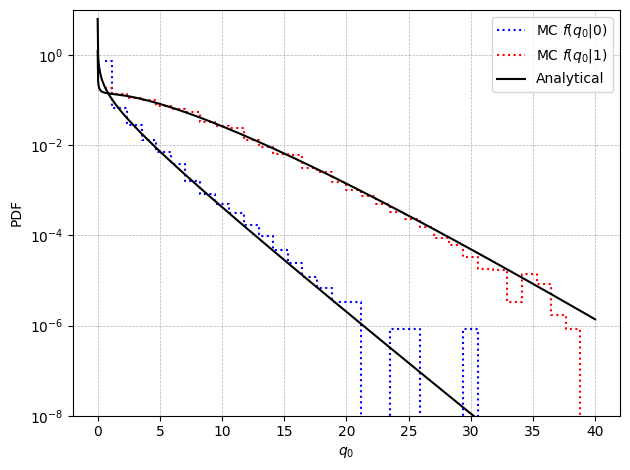

In [8]:
# plot
bins = np.linspace(0, 40, 35)
centers = 0.5 * (bins[:-1] + bins[1:])

# histogram for H0
hist_0, _ = np.histogram(q0_mc_0, bins=bins, density=True)
plt.step(centers, hist_0, where='mid', label=r'MC $f(q_0|0)$', color='blue', linestyle='dotted')

# histogram for H1
hist_1, _ = np.histogram(q0_mc_1, bins=bins, density=True)
plt.step(centers, hist_1, where='mid', label=r'MC $f(q_0|1)$', color='red', linestyle='dotted')

# Theoretical curves
q0_vals = np.linspace(0.001, 40, 1000)
plt.plot(q0_vals, f_q0_given_0(q0_vals), 'k-', label=r'Analytical')

# calculation of Asimov sigma
mu = 0
mu_prime = 1
sigmaA = sigma_asimov_0(mu, mu_prime, s, b)
plt.plot(q0_vals, f_q0_given_mu(q0_vals, mu_prime=mu_1, sigma=sigmaA), 'k-')

plt.yscale('log')
plt.ylim(1e-8, 10)
plt.xlabel(r'$q_0$')
plt.ylabel('PDF')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Significance $Z_0$ 



In [9]:
from scipy.stats import norm
import scipy.stats as stats
# np.random.seed(42)    

tau = 1
mu = 0
s = 10
n_events = 100000
b_values = np.arange(10, 110, 5)  # range of b values
Z0_values = []


# loop over different b values
for b in b_values:
    n_obs = np.random.poisson(lam=mu * s + b, size=n_events)
    m_obs = np.random.poisson(lam=tau * b,    size=n_events)
    q0_mc = np.zeros(n_events)

    for i in range(n_events):
        n = n_obs[i]
        m = m_obs[i]
        mu_hat = max(0.0, (n - m / tau) / s)
        b_hat = m / tau

        first_term = (n + m - (1 + tau) * mu * s) / (2 * (1 + tau))
        second_term = ((n + m - (1 + tau) * mu * s) ** 2 + 4 * (1 + tau) * m * mu * s) / (4 * (1 + tau) ** 2)
        b_hat_mu = first_term + np.sqrt(second_term)

        if mu_hat > 0:
            q0_mc[i] = q0_estimator(n, m, s, mu, tau, mu_hat, b_hat, b_hat_mu)
        else:
            q0_mc[i] = 0.0

    # Filter NaNs
    q0_mc = q0_mc[np.isfinite(q0_mc)]

    # Histogram for p-value calculation
    counts, bins = np.histogram(q0_mc, bins=32, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_width = bins[1] - bins[0]

    # calculate pvalue, using the area under the curve
    # integral from q0 ≥ 16
    mask = bin_centers >= 16
    p_value = np.sum(counts[mask]) * bin_width

    # Z0 from p-value
    # Eq. 1
    Z0 = stats.norm.ppf(1 - p_value) if p_value > 0 else 0
    Z0_values.append(Z0)

/tmp/ipykernel_266000/3577143803.py:3: RuntimeWarning: overflow encountered in scalar multiply
  like_cond = ((mu * s + b_hat_mu) ** n * np.exp(-(mu * s + b_hat_mu))) * \
/tmp/ipykernel_266000/3577143803.py:6: RuntimeWarning: overflow encountered in scalar multiply
  like_max = ((mu_hat * s + b_hat) ** n * np.exp(-(mu_hat * s + b_hat))) * \
/tmp/ipykernel_266000/3577143803.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return -2.0 * np.log(like_cond / like_max)
/tmp/ipykernel_266000/3577143803.py:15: RuntimeWarning: divide by zero encountered in log
  return -2.0 * np.log(like_cond / like_max)
/tmp/ipykernel_266000/3577143803.py:3: RuntimeWarning: overflow encountered in scalar power
  like_cond = ((mu * s + b_hat_mu) ** n * np.exp(-(mu * s + b_hat_mu))) * \
/tmp/ipykernel_266000/3577143803.py:6: RuntimeWarning: overflow encountered in scalar power
  like_max = ((mu_hat * s + b_hat) ** n * np.exp(-(mu_hat * s + b_hat))) * \


### Plot results

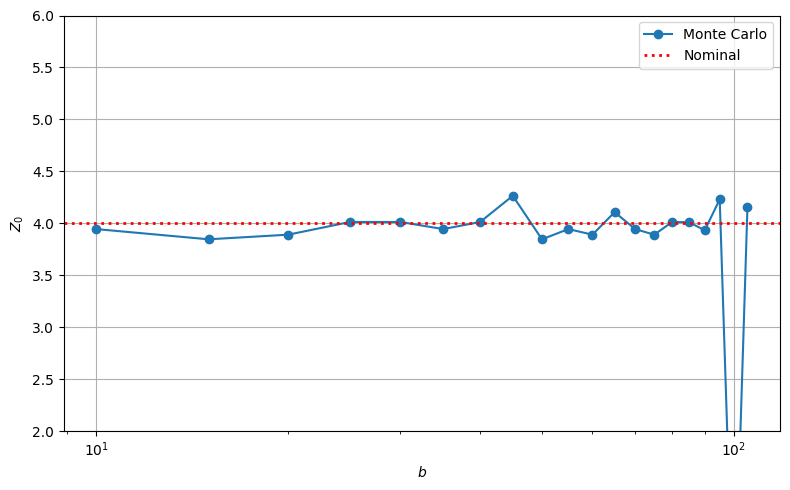

In [10]:
# Plot Z0 vs b
plt.figure(figsize=(8,5))
plt.plot(b_values, Z0_values, 'o-', label='Monte Carlo')
plt.axhline(4, color='red', linestyle='dotted', linewidth=2, label='Nominal')

plt.xlabel('$b$')
plt.ylim([2,6])
plt.ylabel('$Z_0$')
plt.grid(True)
plt.legend()
plt.xscale("log")
plt.tight_layout()
plt.show()

## Median for $q_0$ assuming $\mu'=1$

Plot 4b

In [11]:
# Based on G. Cowan paper [Eur. Phys. J. C (2011) 71: 1554]
np.random.seed(42)

# parameters
mu_1 = 1     # true signal strength (what we assume in data)
mu = 0       # null hypothesis
tau = 1
s_values = [20, 10, 5, 2, 1]
b_vals = np.arange(1, 110, 1)
b_vals = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5,5,6,7,8,9,10, 15 ,20,50]
n_events = 10000


q0_vals_mc_all = []
q0_vals_all = []

for s in s_values:
    q0_vals_mc = []
    q0_vals = []
    for b in b_vals:
        # MONTECARLO
        n_obs = np.random.poisson(lam=mu_1 * s + b, size=n_events)
        m_obs = np.random.poisson(lam=tau * b, size=n_events)
        q0_mc = np.zeros(n_events)

        for i in range(n_events):
            n = n_obs[i]
            m = m_obs[i]

            mu_hat = max(0.0, (n - m / tau) / s)
            b_hat = m / tau

            first_term = (n + m - (1 + tau) * mu * s) / (2 * (1 + tau))
            second_term = ((n + m - (1 + tau) * mu * s) ** 2 + 4 * (1 + tau) * m * mu * s) / (4 * (1 + tau) ** 2)
            b_hat_mu = first_term + np.sqrt(second_term)

            if mu_hat > 0:
                q0_mc[i] = q0_estimator(n, m, s, mu, tau, mu_hat, b_hat, b_hat_mu)

        q0_median = np.median(q0_mc)
        q0_vals_mc.append(q0_median)

        #ASIMOV
        nA = mu_1 * s + b
        mA = tau * b

        mu_hat_A = max(0.0, (nA - mA / tau) / s)
        b_hat_A = mA / tau

        first_term_A = (nA + mA - (1 + tau) * mu * s) / (2 * (1 + tau))
        second_term_A = ((nA + mA - (1 + tau) * mu * s) ** 2 + 4 * (1 + tau) * mA * mu * s) / (4 * (1 + tau) ** 2)
        b_hat_mu_A = first_term_A + np.sqrt(second_term_A)

        q0A = q0_estimator(nA, mA, s, mu, tau, mu_hat_A, b_hat_A, b_hat_mu_A)
        q0_vals.append(q0A)

    q0_vals_all.append(q0_vals)
    q0_vals_mc_all.append(q0_vals_mc)

### Plot results

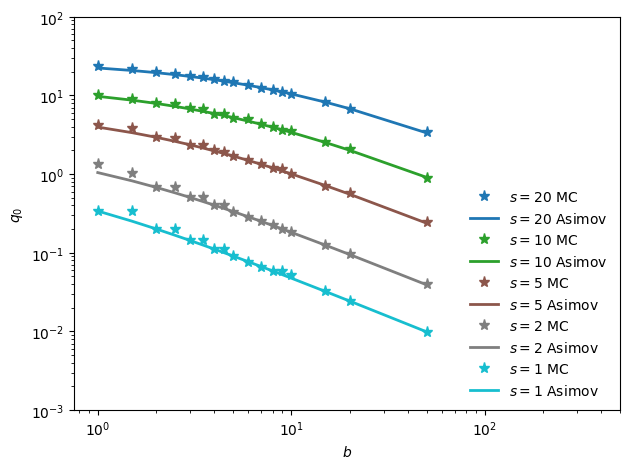

In [12]:
# plots
#plt.figure(figsize=(7, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(s_values)))
for i in range(len(s_values)):
    color = colors[i]
    plt.plot(b_vals, q0_vals_mc_all[i], 
             label=fr"$s = {s_values[i]}$ MC", 
             marker='*', 
             linestyle="None",
             markersize=8,
             color=color)
    plt.plot(b_vals, q0_vals_all[i], 
             label=fr"$s = {s_values[i]}$ Asimov",
             linewidth=2,
             color=color)    

plt.xlabel(r"$b$")
plt.ylim(0.001, 100)
plt.xlim(0.75, 500)
plt.ylabel(r"$q_0$")
plt.yscale("log")
plt.xscale("log")
plt.grid(False)
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
plt.show()

## 2.2. Statistic $q_1$

The following probability density function (Eq. 54), describes the distribution of the discovery statistic $q_1$ when we assume that data is decribed by $\mu'$. This is the theoretical distribution found using Wald and Wilks aproximation. 
\begin{equation}
f(q_{\mu}|\mu') = \Phi\left(\frac{\mu'-\mu}{\sigma} \right)\delta(q_{\mu}) + \frac{1}{2} \frac{1}{\sqrt{2\pi}}\frac{1}{\sqrt{q_{\mu}}}\exp\left[{-\frac{1}{2}\left(\sqrt{q_{\mu}} - \frac{\mu-\mu'}{\sigma} \right)^2 }\right].
\end{equation}

Lets show this aproximation is as good as the Monte Carlo simulation

First, let's define the analytical function

In [13]:
def f_qmu_given_mu_prime(q_mu, mu, mu_prime, sigma):
    """documentation missing"""
    # eq. 54
    q_mu = np.asarray(q_mu)
    result = np.zeros_like(q_mu, dtype=np.float64)
    # first part, for the Dirac delta, q = 0
    delta_flag = (q_mu == 0)
    result[delta_flag] = norm.cdf((mu_prime -mu)/sigma)
    # second part, continue part
    cont_flag = (q_mu > 0)
    q_mu_pos = q_mu[cont_flag]
    result[cont_flag] = (0.5 * (1 / np.sqrt(2 * np.pi * q_mu_pos)) * np.exp((-0.5) * (np.sqrt(q_mu_pos)- (mu-mu_prime)/sigma )**2 ))
    return result

### Asimov $\sigma$ for the previous distribution

In [14]:
def sigma_asimov(mu, mu_prime, s, b, tau):
    """
    Write Documentation
    """
    # Asimov dataset sigma  Ec. [30, 31, 32]
    if mu == mu_prime:
        return 1.0 # Ec. 30 tells that is zero, but we define it as 1 for usability [for students: why this works?]
    
    # Asimov data set
    nA = mu_prime * s + b
    mA = tau * b
    # Asimov estimators
    mu_hat_A = (nA - mA / tau) / s # we allow negative values. check paper
    b_hat_A = mA / tau
    first_term_A = (nA + mA - (1 + tau) * mu * s) / (2 * (1 + tau))
    second_term_A = ((nA + mA - (1 + tau) * mu * s) ** 2 + 4 * (1 + tau) * mA * mu * s) / (4 * (1 + tau) ** 2)
    b_hat_mu_A = first_term_A + np.sqrt(second_term_A)
    # Asimov sigma [Eq. 32]
    sigmaA = np.sqrt(((mu - mu_prime)**2)/q_estimator(nA, mA, s, mu, tau, mu_hat_A, b_hat_A, b_hat_mu_A))
    return sigmaA

Now, let's define the function that obtains the MC simulated $q_{\mu}$

In [15]:
def q_estimator(n, m, s, mu, tau, mu_hat, b_hat, b_hat_mu):
    """
    missing documentation (MC simulation)
    """
    log_like_cond = n*np.log(mu*s + b_hat_mu)   - mu*s     - b_hat_mu + m*np.log(tau*b_hat_mu) -tau*b_hat_mu
    log_like_max  = n*np.log(mu_hat*s + b_hat)  - mu_hat*s - b_hat    + m*np.log(tau*b_hat)    -tau*b_hat

    if mu_hat <= mu:
        return (-2.0)*(log_like_cond - log_like_max)
    elif mu_hat > mu:
        return 0

### Run the simulation

/tmp/ipykernel_266000/535902587.py:5: RuntimeWarning: divide by zero encountered in log
  log_like_cond = n*np.log(mu*s + b_hat_mu)   - mu*s     - b_hat_mu + m*np.log(tau*b_hat_mu) -tau*b_hat_mu
/tmp/ipykernel_266000/535902587.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  log_like_cond = n*np.log(mu*s + b_hat_mu)   - mu*s     - b_hat_mu + m*np.log(tau*b_hat_mu) -tau*b_hat_mu
/tmp/ipykernel_266000/535902587.py:6: RuntimeWarning: divide by zero encountered in log
  log_like_max  = n*np.log(mu_hat*s + b_hat)  - mu_hat*s - b_hat    + m*np.log(tau*b_hat)    -tau*b_hat
/tmp/ipykernel_266000/535902587.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  log_like_max  = n*np.log(mu_hat*s + b_hat)  - mu_hat*s - b_hat    + m*np.log(tau*b_hat)    -tau*b_hat


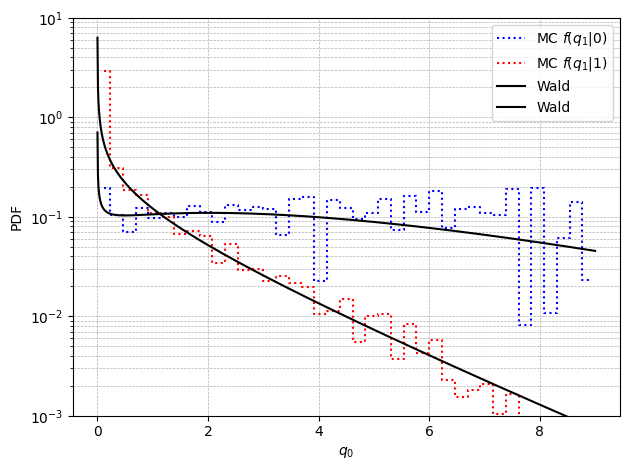

In [19]:
# Based on G. Cowan paper [Eur. Phys. J. C (2011) 71: 1554]
#np.random.seed(11)

# parameters
tau = 1
b = 10 #9
s = 10 #6
n_events = 100000

# MC simulation
mu = 1             # statistic of interest
mu_prime = 0       # data
n_obs = np.random.poisson(lam=mu_prime * s + b, size=n_events)
m_obs = np.random.poisson(lam=tau * b, size=n_events)
q10_mc = np.zeros(n_events)

for i in range(n_events):
    n = n_obs[i]
    m = m_obs[i]
    mu_hat = max(0.0, (n - m / tau) / s)
    b_hat = m / tau

    first_term = (n + m - (1 + tau) * mu * s) / (2 * (1 + tau))
    second_term = ((n + m - (1 + tau) * mu * s) ** 2 + 4 * (1 + tau) * m * mu * s) / (4 * (1 + tau) ** 2)
    b_hat_mu = first_term + np.sqrt(second_term)

    if mu_hat > 0 or True:
        q10_mc[i] = q_estimator(n, m, s, mu, tau, mu_hat, b_hat, b_hat_mu)


# MC simulation
mu = 1             # statistic of interest
mu_prime = 1       # data
n_obs = np.random.poisson(lam=mu_prime * s + b, size=n_events)
m_obs = np.random.poisson(lam=tau * b, size=n_events)
q11_mc = np.zeros(n_events)

for i in range(n_events):
    n = n_obs[i]
    m = m_obs[i]
    mu_hat = max(0.0, (n - m / tau) / s)
    b_hat = m / tau

    first_term = (n + m - (1 + tau) * mu * s) / (2 * (1 + tau))
    second_term = ((n + m - (1 + tau) * mu * s) ** 2 + 4 * (1 + tau) * m * mu * s) / (4 * (1 + tau) ** 2)
    b_hat_mu = first_term + np.sqrt(second_term)

    if mu_hat > 0 or True:
        q11_mc[i] = q_estimator(n, m, s, mu, tau, mu_hat, b_hat, b_hat_mu)


# plot
bins = np.linspace(0, 9, 40)
centers = 0.5 * (bins[:-1] + bins[1:])

# histogram for 
hist_0, _ = np.histogram(q10_mc, bins=bins, density=True)
plt.step(centers, hist_0, where='mid', label=r'MC $f(q_1|0)$', color='blue', linestyle='dotted')

# histogram for H1
hist_1, _ = np.histogram(q11_mc, bins=bins, density=True)
plt.step(centers, hist_1, where='mid', label=r'MC $f(q_1|1)$', color='red', linestyle='dotted')

# Theoretical curves
q1_vals = np.linspace(0.001, 9, 1000)

mu = 1             # statistic of interest
mu_prime = 0       # data
sigmaA = sigma_asimov(mu, mu_prime, s, b, tau) # calculation of Asimov sigma
plt.plot(q1_vals, f_qmu_given_mu_prime(q1_vals, mu=mu, mu_prime=mu_prime, sigma=sigmaA), 'k-', label=r'Wald')

mu = 1             # statistic of interest
mu_prime = 1       # data
sigmaA = sigma_asimov(mu, mu_prime, s, b, tau) # calculation of Asimov sigma
plt.plot(q1_vals, f_qmu_given_mu_prime(q1_vals, mu=mu, mu_prime=mu_prime, sigma=sigmaA), 'k-', label=r'Wald')


plt.yscale('log')
plt.ylim(1e-3, 10)
plt.xlabel(r'$q_0$')
plt.ylabel('PDF')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## 2.3. Statistic $\tilde{q_1}$